# This notebook reconstructs alternative buffers to create additional data
Ethnologue data cannot be shared freely due to copyright issues. Therefore you can only view the output of the cells.

# Setup

In [ ]:
import sys, os, time
import matplotlib.pyplot as plt

# Math, data
import numpy as np
import pandas as pd
pd.set_option('display.width', 140)

# GIS packages
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Polygon, Point
import pyproj
import georasters as gr
import fiona
import fiona.crs
import geopandas as gp
import geopandas.tools as gpt
gpd = gp
import dask_geopandas

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

# Various other packages
import isounidecode         # Decode and encode text
import itertools
from functools import reduce

# Paths
proot = '/work/Replication_Dickens_2022/data/'
pathout = proot + 'Ethnologue/'
pathstats = proot + 'stats/'
pathethno = '' # Since the Ethnologed is protected under copy rights we can't upload the dataset.

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/users/ozak/micromamb

In [ ]:
def Borders(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.type.isin(["LineString", "MultiLineString"])
        intersections.loc[poly_ix] = intersections[poly_ix]#.buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gpd.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        return gpd.GeoDataFrame(
            [],
            columns=list(set(df1.columns).union(df2.columns)) + ["__idx1", "__idx2"],
            crs=df1.crs,
        )
    
def _overlay_intersection(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.geom_type.isin(["Polygon", "MultiPolygon"])
        intersections.loc[poly_ix] = intersections[poly_ix].buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gp.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        result = df1.iloc[:0].merge(
            df2.iloc[:0].drop(df2.geometry.name, axis=1),
            left_index=True,
            right_index=True,
            suffixes=("_1", "_2"),
        )
        result["__idx1"] = None
        result["__idx2"] = None
        return result[
            result.columns.drop(df1.geometry.name).tolist() + [df1.geometry.name]
        ]

In [ ]:
# Drop repeated pairs
def drop_repeated(df, cols):
    df1 = df[cols].copy()
    df1['reps'] = df1.apply(lambda x: list(set(x[cols].astype(str))), axis=1)
    df1['reps'] = df1.reps.apply(lambda x: '-'.join(x))
    df1 = df1.drop_duplicates('reps')
    df1 = df1.drop('reps', axis=1).reset_index(drop=True)
    return df1

# Using Original Data
## Import original replication files provided with paper
* We import only shapefiles to show construction and difference/similarity. 
* We import only the file for the 50km buffer (i.e., the 100km diameter)

Main original replication data file with all pairwise data based on buffers of 50kms

In [ ]:
dfor = pd.read_stata(proot + 'EJ_Dickens_Border_100km.dta')
dfor

/tmp/ipykernel_1329554/3197352363.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')


,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
1,AAA-NGA-OKE-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Okpe,oke,Nigeria,Niger-Congo,0.628569,...,oke,aaa,oke,GHOTUO,OKPE,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
2,AAB-NGA-JID-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Bu,jid,Nigeria,Niger-Congo,0.833333,...,jid,aab,jid,TESU,BU_NIGERIA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
3,AAB-NGA-RIN-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Nungu,rin,Nigeria,Niger-Congo,NaN,...,rin,aab,rin,TESU,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
4,AAB-NGA-TDV-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Toro,tdv,Nigeria,Niger-Congo,0.532142,...,tdv,aab,tdv,TESU,TORO,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15598,ZYN-CHN-YUE-CHN,"Zhuang, Yongnan",zyn,China,Tai-Kadai,"Chinese, Yue",yue,China,Sino-Tibetan,0.813015,...,yue,zyn,yue,NINGMING_YONGNAN_ZHUANG,CANTONESE,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15599,ZZJ-CHN-CMN-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,"Chinese, Mandarin",cmn,China,Sino-Tibetan,0.865388,...,cmn,zzj,cmn,LONGZHOU_ZHUANG,KUNMING_MANDARIN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15600,ZZJ-CHN-IUM-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Iu Mien,ium,China,Hmong-Mien,0.844456,...,ium,zzj,ium,LONGZHOU_ZHUANG,CHIANGRAI_MIEN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Hmong-Mien,Mienic,Mian-Jin",156.0,156.0,Asia
15601,ZZJ-CHN-TYZ-VNM,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Tay,tyz,Vietnam,Tai-Kadai,0.528902,...,tyz,zzj,tyz,LONGZHOU_ZHUANG,TAY,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central",156.0,704.0,Asia


In [ ]:
dfor.loc[dfor.identifier=='SPA-MEX-SPA-GTM']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [ ]:
dfor.loc[dfor.identifier=='SPA-GTM-SPA-MEX']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [ ]:
dfor.loc[dfor.identifier=='AAA-NGA-EMA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa


In [ ]:
dfor.loc[dfor.identifier=='EMA-NGA-AAA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


# New Data
## Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
###  Import data and transform CRS

In [ ]:
ethno = gp.read_file(pathethno + 'langa.shp')
#ethno = ethno.to_crs(cea)
#ethno['key'] = 0
ethno.head()

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,"116,000,000 in Russian Federation (2002 census)",116000000,"Indo-European, Slavic, East",L,Indo-European,INDO-EUROPEAN,Russian Federation,rus,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,ENG-USA,eng-USA,eng-us,eng-US,English,English,ENGLISH,English,Americas,United States,"215,000,000 in United States (2000 census)",215000000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,United States,eng,"MULTIPOLYGON (((-75.11965 19.97388, -75.11741 ..."
2,POR-BRA,por-BRA,por-br,por-BR,Portuguese,Portuguese,PORTUGUESE,Portuguese,Americas,Brazil,"163,000,000 in Brazil (1998)",163000000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Brazil,por,"MULTIPOLYGON (((-52.13058 -31.97901, -52.12447..."
3,ENG-AUS,eng-AUS,eng-au,eng-AS,English,English,ENGLISH,English,Pacific,Australia,"17,400,000 in Australia (2006)",17400000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Australia,eng,"MULTIPOLYGON (((147.36099 -43.08758, 147.36375..."
4,CMN-CHN,cmn-CHN,cmn-cn,cmn-CH,Mandarin Chinese,"Chinese, Mandarin","CHINESE, MANDARIN","Chinese, Mandarin",Asia,China,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."


In [ ]:
ethno = ethno.loc[ethno.LMP_POP1>0].reset_index(drop=True)

In [ ]:
ethno.shape

(7327, 19)

## Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
Find duplicated languages x country. Unlike v16, v17 has a duplicated language

In [ ]:
ethno.loc[ethno.duplicated('ID')]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry


## Create all pairs of languages/countries

In [ ]:
import multiprocessing
nb_cpus = multiprocessing.cpu_count()
print(nb_cpus)

import dask.dataframe as dd
from dask.distributed import Client, progress
client = Client(processes=True,threads_per_worker=1, n_workers=nb_cpus,memory_limit='64G')

# Create a Dask client to utilize multiple cores
client = Client()
client

128


/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34835 instead
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35263 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35263/status,
Dashboard: http://127.0.0.1:35263/status,Workers: 16
Total threads: 128,Total memory: 500.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34085,Workers: 16
Dashboard: http://127.0.0.1:35263/status,Total threads: 128
Started: Just now,Total memory: 500.00 GiB
Comm: tcp://127.0.0.1:42271,Total threads: 8
Dashboard: http://127.0.0.1:42149/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:42333,


In [ ]:
ddethno = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno2 = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno['geometry'] = ddethno['geometry'].buffer(0.2)

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:6699: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


In [ ]:
pairs = ddethno.sjoin(ddethno2, predicate="intersects").compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: Us

In [ ]:
pairs.shape

(74396, 38)

In [ ]:
pairs.columns = [c.replace('_left', '_1').replace('_right', '_2') for c in pairs.columns]

In [ ]:
pairs.loc[(pairs.ID_1=='MVE-PAK')&(pairs.ID_2=='RWR-IND')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,CNT_2,C1_2,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2
427,MVE-PAK,mve-PAK,mve-pk,mve-PK,Marwari,Marwari,MARWARI,Marwari,Asia,Pakistan,...,Asia,India,"5,600,000 in India (2007 SIL)",5600000,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,India,rwr


In [ ]:
pairs = pairs.merge(ethno[['ID', 'geometry']], how='left', left_on='ID_1', right_on='ID', suffixes=['', "_1"])
pairs.head()

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_1
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,"121,000,000 in Japan (1985)",121000000,Japonic,L,Japonic,JAPONIC,Japan,jpn,RUS-RUS,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,JPN-JPN,jpn-JPN,jpn-jp,jpn-JA,Japanese,Japanese,JAPANESE,Japanese,Asia,Japan,...,"121,000,000 in Japan (1985)",121000000,Japonic,L,Japonic,JAPONIC,Japan,jpn,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,RUS-RUS,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
3,CMN-CHN,cmn-CHN,cmn-cn,cmn-CH,Mandarin Chinese,"Chinese, Mandarin","CHINESE, MANDARIN","Chinese, Mandarin",Asia,China,...,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."
4,KHK-MNG,khk-MNG,khk-mn,khk-MG,Halh Mongolian,"Mongolian, Halh","MONGOLIAN, HALH","Mongolian, Halh",Asia,Mongolia,...,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,KHK-MNG,"POLYGON ((101.05564 51.29117, 101.03179 51.136..."


In [ ]:
pairs['geometry'] = pairs['geometry_1'].values
pairs[['ID_1', 'ID', 'geometry', 'geometry_1']].head()

,ID_1,ID,geometry,geometry_1
0,RUS-RUS,RUS-RUS,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43...","MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,RUS-RUS,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43...","MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
3,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."
4,KHK-MNG,KHK-MNG,"POLYGON ((101.05564 51.29117, 101.03179 51.136...","POLYGON ((101.05564 51.29117, 101.03179 51.136..."


In [ ]:
pairs = pairs.drop(columns=['ID', 'geometry_1'])

In [ ]:
pairs = pairs.to_crs(cea)

In [ ]:
pairs = pairs.merge(ethno[['ID', 'geometry']].to_crs(cea), how='left', left_on='ID_2', right_on='ID', suffixes=['_1', "_2"])
pairs[['ID_1', 'ID_2', 'ID', 'geometry_1', 'geometry_2']].head()

,ID_1,ID_2,ID,geometry_1,geometry_2
0,RUS-RUS,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((5022045.912 4345314.017, 50171...","MULTIPOLYGON (((14944468.315 3612072.777, 1494..."
1,JPN-JPN,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((14944468.315 3612072.777, 1494...","MULTIPOLYGON (((14944468.315 3612072.777, 1494..."
2,RUS-RUS,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((5022045.912 4345314.017, 50171...","MULTIPOLYGON (((12095297.711 2069921.530, 1209..."
3,CMN-CHN,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((12095297.711 2069921.530, 1209...","MULTIPOLYGON (((12095297.711 2069921.530, 1209..."
4,KHK-MNG,CMN-CHN,CMN-CHN,"POLYGON ((11249462.721 4957243.443, 11246807.3...","MULTIPOLYGON (((12095297.711 2069921.530, 1209..."


In [ ]:
%time
pairs = pairs.loc[pairs['ID_1']!=pairs['ID_2']].reset_index(drop=True)
pairs.shape

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 18.1 µs


(67069, 40)

In [ ]:
pairs[['ID_1', 'ID_2', 'NAME2_1', 'NAME2_2']].head()

,ID_1,ID_2,NAME2_1,NAME2_2
0,RUS-RUS,JPN-JPN,RUSSIAN,JAPANESE
1,RUS-RUS,CMN-CHN,RUSSIAN,"CHINESE, MANDARIN"
2,KHK-MNG,CMN-CHN,"MONGOLIAN, HALH","CHINESE, MANDARIN"
3,MVF-CHN,CMN-CHN,"MONGOLIAN, PERIPHERAL","CHINESE, MANDARIN"
4,KHG-CHN,CMN-CHN,"TIBETAN, KHAMS","CHINESE, MANDARIN"


We have dropped all same pair language/countries, now let's drop all same langauge pairs that are in differenct countries (e.g., SPA-MEX and SPA-GTM). Special case MVE-PAK and RWR-IND are the same language (NAME2) even though they have different ISO codes. It's not clear there is a reason for different ISO code, so we also drop them

(see https://wikitongues.org/languages/mve/, https://wikitongues.org/languages/rwr/, https://www.ethnologue.com/language/rwr/, https://www.ethnologue.com/language/mve/)

**This differs from Dickens, he seems to keep these**

In [ ]:
pairs.loc[(pairs['ID_1']=='SPA-MEX')& (pairs['ID_2']=='SPA-GTM')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2
419,SPA-MEX,spa-MEX,spa-mx,spa-MX,Spanish,Spanish,SPANISH,Spanish,Americas,Mexico,...,"4,670,000 in Guatemala (1995)",4670000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Guatemala,spa,SPA-GTM,"MULTIPOLYGON (((-10157007.858 1687135.375, -10..."


In [ ]:
pairs = pairs.loc[pairs['NAME2_1']!=pairs['NAME2_2']].reset_index(drop=True)
#pairs = pairs.loc[(pairs['ID_1']!='ALN-SRB') & (pairs['ID_2']!='ALN-SRB')].reset_index(drop=True)
pairs.shape

(65681, 40)

In [ ]:
%time
non_repeated_pairs = drop_repeated(pairs, ['ID_1', 'ID_2'])

CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 17.9 µs


In [ ]:
non_repeated_pairs

,ID_1,ID_2
0,RUS-RUS,JPN-JPN
1,RUS-RUS,CMN-CHN
2,KHK-MNG,CMN-CHN
3,MVF-CHN,CMN-CHN
4,KHG-CHN,CMN-CHN
...,...,...
35819,DJE-BFA,HAU-BFA
35820,BHE-PAK,AEQ-PAK
35821,AEQ-PAK,BHE-PAK
35822,XNB-TWN,SXR-TWN


In [ ]:
pairs2 = pairs.loc[(pairs.ID_1=='ENG-USA')&(pairs.ID_2=='SPA-MEX')].reset_index()
pairs2[['ID_1', 'ID_2', 'geometry_1', 'geometry_2']]
pairs2['buffer_2'] = pairs2.apply(lambda x: x.geometry_1.buffer(50000).intersection(x.geometry_2), axis=1)
pairs2['buffer_1'] = pairs2.apply(lambda x: x.geometry_2.buffer(50000).intersection(x.geometry_1), axis=1)

<AxesSubplot:>

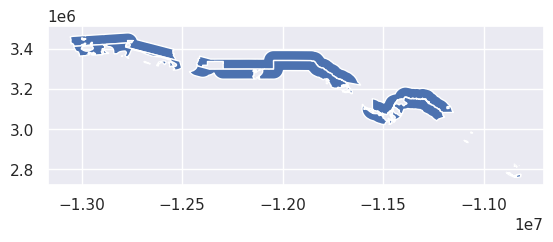

In [ ]:
pairs3 = gp.GeoDataFrame(pd.concat([pairs2[['ID_1', 'ID_2', 'buffer_1']].rename(columns={'buffer_1':'geometry'}), pairs2[['ID_1', 'ID_2', 'buffer_2']].rename(columns={'buffer_2':'geometry'})]), 
                 columns=['ID_1', 'ID_2', 'geometry'],
                 crs=cea, geometry='geometry')
pairs3.plot()

# New Data - Buffers

In [ ]:
ddpairs = dask_geopandas.from_geopandas(pairs, npartitions=20)

In [ ]:
%time
ddpairs['buffer_2'] = ddpairs.apply(lambda x: x.geometry_1.buffer(50000).intersection(x.geometry_2), axis=1, meta=(None, 'geometry'))
ddpairs['buffer_1'] = ddpairs.apply(lambda x: x.geometry_2.buffer(50000).intersection(x.geometry_1), axis=1, meta=(None, 'geometry'))
#borders = ddpairs.compute(scheduler="threads", num_workers=120)
buffers = ddpairs.compute()

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 26.7 µs


In [ ]:
buffers[['ID_1', 'ID_2', 'buffer_1', 'buffer_2']]

,ID_1,ID_2,buffer_1,buffer_2
0,RUS-RUS,JPN-JPN,MULTIPOLYGON (((15798275.99722172 4580792.0723...,MULTIPOLYGON (((15832575.73212238 4511966.4460...
1,RUS-RUS,CMN-CHN,"POLYGON ((13072217.383952694 4841713.42243159,...",MULTIPOLYGON (((14776502.069533493 4546876.801...
2,KHK-MNG,CMN-CHN,"POLYGON ((10715363.407899061 4354297.16279662,...",POLYGON ((10842561.151461825 4259957.376759018...
3,MVF-CHN,CMN-CHN,MULTIPOLYGON (((10889648.590294197 4301787.457...,MULTIPOLYGON (((10787585.679741485 4277137.333...
4,KHG-CHN,CMN-CHN,"POLYGON ((11314343.319362994 3114405.91615483,...","POLYGON ((11388374.262635808 3261457.37307176,..."
...,...,...,...,...
65676,HAU-BFA,DJE-BFA,MULTIPOLYGON (((199464.60131269094 1339550.796...,MULTIPOLYGON (((176438.6099200672 1376365.0908...
65677,BHE-PAK,AEQ-PAK,POLYGON ((7734927.606012514 2707613.9355502585...,"POLYGON ((7741831.356010162 2696790.680774468,..."
65678,AEQ-PAK,BHE-PAK,"POLYGON ((7741831.356010162 2696790.680774468,...",POLYGON ((7734927.606012514 2707613.9355502585...
65679,XNB-TWN,SXR-TWN,POLYGON ((13457178.135234285 2510337.991647421...,"POLYGON ((13437662.82662281 2504109.27131686, ..."


In [ ]:
buffers['identifier'] = buffers['ID_1'] + '-' + buffers['ID_2']

In [ ]:
buffers1_geo = gp.GeoDataFrame(buffers[['identifier', 'ID_1', 'ID_2', 'buffer_1']], crs=cea, geometry='buffer_1')
buffers1_geo.head()

,identifier,ID_1,ID_2,buffer_1
0,RUS-RUS-JPN-JPN,RUS-RUS,JPN-JPN,"MULTIPOLYGON (((15798275.997 4580792.072, 1580..."
1,RUS-RUS-CMN-CHN,RUS-RUS,CMN-CHN,"POLYGON ((13072217.384 4841713.422, 13072230.8..."
2,KHK-MNG-CMN-CHN,KHK-MNG,CMN-CHN,"POLYGON ((10715363.408 4354297.163, 10720027.3..."
3,MVF-CHN-CMN-CHN,MVF-CHN,CMN-CHN,"MULTIPOLYGON (((10889648.590 4301787.458, 1088..."
4,KHG-CHN-CMN-CHN,KHG-CHN,CMN-CHN,"POLYGON ((11314343.319 3114405.916, 11313568.8..."


In [ ]:
buffers2_geo = gp.GeoDataFrame(buffers[['identifier', 'ID_1', 'ID_2', 'buffer_2']], crs=cea, geometry='buffer_2')
buffers2_geo.head()

,identifier,ID_1,ID_2,buffer_2
0,RUS-RUS-JPN-JPN,RUS-RUS,JPN-JPN,"MULTIPOLYGON (((15832575.732 4511966.446, 1582..."
1,RUS-RUS-CMN-CHN,RUS-RUS,CMN-CHN,"MULTIPOLYGON (((14776502.070 4546876.802, 1477..."
2,KHK-MNG-CMN-CHN,KHK-MNG,CMN-CHN,"POLYGON ((10842561.151 4259957.377, 10837535.4..."
3,MVF-CHN-CMN-CHN,MVF-CHN,CMN-CHN,"MULTIPOLYGON (((10787585.680 4277137.333, 1078..."
4,KHG-CHN-CMN-CHN,KHG-CHN,CMN-CHN,"POLYGON ((11388374.263 3261457.373, 11391188.7..."


In [ ]:
buffers1_geo.to_file(pathout + 'ethnologue_buffers_alt1_v16.json', driver="GeoJSON")
buffers2_geo.to_file(pathout + 'ethnologue_buffers_alt2_v16.json', driver="GeoJSON")

No need to recreate overlap etc, we can use what we created in [Replication-Construct-Buffers-Touch-v17.ipynb](/work/Replication_Dickens_2022/Replication-Construct-Buffers-Touch-v17.ipynb)

# New Data - Spatial Stats for New Buffers

In [ ]:
buffers1_geo = gp.read_file(pathout + 'ethnologue_buffers_alt1_v16.json', driver="GeoJSON")
buffers2_geo = gp.read_file(pathout + 'ethnologue_buffers_alt2_v16.json', driver="GeoJSON")

Work with CSI data to compute spatial statistics

In [ ]:
CSI = os.listdir(proot + 'CSI')

In [ ]:
CSI.remove('ReadMe.txt')
CSI.sort()
CSI

['dif2AverageCalories.tif',
 'dif2AverageCalories0.tif',
 'dif2AverageCaloriesNo0.tif',
 'dif2OptCalories.tif',
 'dif2OptCalories0.tif',
 'dif2OptCaloriesNo0.tif',
 'difAverageCalories.tif',
 'difAverageCalories0.tif',
 'difAverageCaloriesNo0.tif',
 'difOptCalories.tif',
 'difOptCalories0.tif',
 'difOptCaloriesNo0.tif',
 'post1500AverageCalories.tif',
 'post1500AverageCalories0.tif',
 'post1500AverageCaloriesNo0.tif',
 'post1500OptCalories.tif',
 'post1500OptCalories0.tif',
 'post1500OptCaloriesNo0.tif',
 'pre15002AverageCalories.tif',
 'pre15002AverageCalories0.tif',
 'pre15002AverageCaloriesNo0.tif',
 'pre15002OptCalories.tif',
 'pre15002OptCalories0.tif',
 'pre15002OptCaloriesNo0.tif',
 'pre1500AverageCalories.tif',
 'pre1500AverageCalories0.tif',
 'pre1500AverageCaloriesNo0.tif',
 'pre1500OptCalories.tif',
 'pre1500OptCalories0.tif',
 'pre1500OptCaloriesNo0.tif']

In [ ]:
buffers1_geo = buffers1_geo.to_crs(wgs84)
buffers2_geo = buffers2_geo.to_crs(wgs84)

In [ ]:
%%time
for r in CSI:
    print(r.replace('.tif', ''))
    # Import raster
    csi = gr.from_file(proot + '/CSI/' + r)
    # Compute stats for first section of buffer
    out= csi.stats(buffers1_geo, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[3:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_' + r.replace('.tif', '') + '_alt.dta', version=117, write_index=False)    
    # Compute stats for second section of buffer    
    out= csi.stats(buffers2_geo, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[3:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_' + r.replace('.tif', '') + '_alt2.dta', version=117, write_index=False)

dif2AverageCalories
ERROR! Session/line number was not unique in database. History logging moved to new session 23494
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
dif2AverageCalories0
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
dif2AverageCaloriesNo0
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
dif2OptCalories
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
dif2OptCalories0
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 

In [ ]:
%%time
out = []
for r in CSI:
    print(r.replace('.tif', ''))
    out1 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_' + r.replace('.tif', '') + '_alt.dta')   
    out1 = out1.set_index(['identifier', 'ID_1', 'ID_2'])
    out2 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_' + r.replace('.tif', '') + '_alt2.dta')
    out2 = out2.set_index(['identifier', 'ID_1', 'ID_2'])
    out.append((out1[out1.columns] - out2[out1.columns]).abs())

dif2AverageCalories
dif2AverageCalories0
dif2AverageCaloriesNo0
dif2OptCalories
dif2OptCalories0
dif2OptCaloriesNo0
difAverageCalories
difAverageCalories0
difAverageCaloriesNo0
difOptCalories
difOptCalories0
difOptCaloriesNo0
post1500AverageCalories
post1500AverageCalories0
post1500AverageCaloriesNo0
post1500OptCalories
post1500OptCalories0
post1500OptCaloriesNo0
pre15002AverageCalories
pre15002AverageCalories0
pre15002AverageCaloriesNo0
pre15002OptCalories
pre15002OptCalories0
pre15002OptCaloriesNo0
pre1500AverageCalories
pre1500AverageCalories0
pre1500AverageCaloriesNo0
pre1500OptCalories
pre1500OptCalories0
pre1500OptCaloriesNo0
CPU times: user 9.85 s, sys: 229 ms, total: 10.1 s
Wall time: 12 s


In [ ]:
out = pd.concat(out, axis=1)

In [ ]:
out.to_stata(proot + 'Dickens_AltBuf_v16_absdif.dta', version=117)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4a945f27-2c4c-4244-8f3b-ab6dff812a2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>